In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

sns.set_context('notebook')
pd.set_option('float_format', '{:6.2f}'.format)

In [2]:
pd.read_csv("Kenya_goods_export_2012-2022_HS2.csv")

,HS2,HS2 ID,Section,Section ID,Trade Value,Year
0,Live animals,101,Animal Products,1,5422344,2012
1,Meat & edible offal,102,Animal Products,1,29028801,2012
2,"Fish, crustaceans, & molluscs",103,Animal Products,1,86858912,2012
3,"Edible products of animal origin, n.e.s.",104,Animal Products,1,12855435,2012
4,"Animal originated products, n.e.s.",105,Animal Products,1,1253498,2012
...,...,...,...,...,...,...
1051,Weapons,1993,Weapons,19,2127,2022
1052,"Furniture, bedding, lamps, & prefab buildings",2094,Miscellaneous,20,23855887,2022
1053,"Toys, games, & sports",2095,Miscellaneous,20,31707915,2022
1054,Misc. manufactures,2096,Miscellaneous,20,13521901,2022


In [3]:
Kenya = pd.read_csv("Kenya_goods_export_2012-2022_HS2.csv")

In [4]:
Kenya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   HS2          1056 non-null   object
 1   HS2 ID       1056 non-null   int64 
 2   Section      1056 non-null   object
 3   Section ID   1056 non-null   int64 
 4   Trade Value  1056 non-null   int64 
 5   Year         1056 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 49.6+ KB


In [5]:
Kenya.mean(numeric_only=True)

HS2 ID             998.71
Section ID           9.50
Trade Value   67170807.23
Year              2017.00
dtype: float64

In [6]:
df = pd.read_csv("Kenya_goods_export_2012-2022_HS2.csv")

In [7]:
summary = df.describe()

In [8]:
print(summary)

       HS2 ID  Section ID   Trade Value    Year
count 1056.00     1056.00       1056.00 1056.00
mean   998.71        9.50   67170807.23 2017.00
std    579.96        5.52  177652959.64    3.16
min    101.00        1.00        388.00 2012.00
25%    499.75        4.75    2509406.50 2014.00
50%   1048.50       10.00   14994831.50 2017.00
75%   1572.25       15.00   64396931.50 2020.00
max   2197.00       21.00 1750143095.00 2022.00


In [9]:
df['Industry_Count'] = df.groupby('Section')['Section'].transform('count')

In [10]:
print(df)

                                                HS2  HS2 ID  \
0                                      Live animals     101   
1                               Meat & edible offal     102   
2                     Fish, crustaceans, & molluscs     103   
3          Edible products of animal origin, n.e.s.     104   
4                Animal originated products, n.e.s.     105   
...                                             ...     ...   
1051                                        Weapons    1993   
1052  Furniture, bedding, lamps, & prefab buildings    2094   
1053                          Toys, games, & sports    2095   
1054                             Misc. manufactures    2096   
1055                                 Art & antiques    2197   

                Section  Section ID  Trade Value  Year  Industry_Count  
0       Animal Products           1      5422344  2012              55  
1       Animal Products           1     29028801  2012              55  
2       Animal Products 

In [11]:
industry_counts = df.groupby('Section')['Section'].nunique()

In [12]:
print(industry_counts)

Section
Animal Hides                        1
Animal Products                     1
Animal and Vegetable Bi-Products    1
Arts and Antiques                   1
Chemical Products                   1
Foodstuffs                          1
Footwear and Headwear               1
Instruments                         1
Machines                            1
Metals                              1
Mineral Products                    1
Miscellaneous                       1
Paper Goods                         1
Plastics and Rubbers                1
Precious Metals                     1
Stone And Glass                     1
Textiles                            1
Transportation                      1
Vegetable Products                  1
Weapons                             1
Wood Products                       1
Name: Section, dtype: int64


In [13]:
industry_counts = df.groupby('Section')['Section'].count()
print(industry_counts)

Section
Animal Hides                         33
Animal Products                      55
Animal and Vegetable Bi-Products     11
Arts and Antiques                    11
Chemical Products                   121
Foodstuffs                           99
Footwear and Headwear                44
Instruments                          33
Machines                             22
Metals                              121
Mineral Products                     33
Miscellaneous                        33
Paper Goods                          33
Plastics and Rubbers                 22
Precious Metals                      11
Stone And Glass                      33
Textiles                            154
Transportation                       44
Vegetable Products                   99
Weapons                              11
Wood Products                        33
Name: Section, dtype: int64


In [14]:
total_products = industry_counts.sum()
print("Total Products across all Industries:", total_products)

Total Products across all Industries: 1056


#This is the Industry Trade value

In [15]:
industry_trade_value = df.groupby('Section')['Trade Value'].sum()
highest_trade_value_industry = industry_trade_value.idxmax()
highest_trade_value = industry_trade_value.max()
lowest_trade_value_industry = industry_trade_value.idxmin()
lowest_trade_value = industry_trade_value.min()

#Highest and lowest value of trade value within an Industry


print(f"The industry with the lowest trade value is '{lowest_trade_value_industry}' with a total trade value of {lowest_trade_value}.")
print(f"The industry with the highest trade value is '{highest_trade_value_industry}' with a total trade value of {highest_trade_value}.")

The industry with the lowest trade value is 'Weapons' with a total trade value of 6026495.
The industry with the highest trade value is 'Vegetable Products' with a total trade value of 30098099860.


In [16]:
df.describe(include="all")

,HS2,HS2 ID,Section,Section ID,Trade Value,Year,Industry_Count
count,1056,1056.00,1056,1056.00,1056.00,1056.00,1056.00
unique,96,NaN,21,NaN,NaN,NaN,NaN
top,Live animals,NaN,Textiles,NaN,NaN,NaN,NaN
freq,11,NaN,154,NaN,NaN,NaN,NaN
mean,NaN,998.71,NaN,9.50,67170807.23,2017.00,83.88
std,NaN,579.96,NaN,5.52,177652959.64,3.16,46.91
min,NaN,101.00,NaN,1.00,388.00,2012.00,11.00
25%,NaN,499.75,NaN,4.75,2509406.50,2014.00,33.00
50%,NaN,1048.50,NaN,10.00,14994831.50,2017.00,99.00
75%,NaN,1572.25,NaN,15.00,64396931.50,2020.00,121.00


In [17]:
raw = pd.read_csv("Kenya_goods_export_2012-2022_HS2.csv")
# Strip whitespace from column names
raw.columns = [x.strip() for x in raw.columns]

# Print shape and data types
print(raw.shape)
print(raw.dtypes)

(1056, 6)
HS2            object
HS2 ID          int64
Section        object
Section ID      int64
Trade Value     int64
Year            int64
dtype: object


In [18]:
print(raw.describe().T[['min', 'mean', 'max', 'std']])

                min        mean           max          std
HS2 ID       101.00      998.71       2197.00       579.96
Section ID     1.00        9.50         21.00         5.52
Trade Value  388.00 67170807.23 1750143095.00 177652959.64
Year        2012.00     2017.00       2022.00         3.16


In [19]:
df = Kenya 

# Assuming df contains the trade data for Kenya

# Group the data by 'Year' and calculate the sum, mean, minimum, and maximum of the trade values for each year
yearly_trade_sum = df.groupby('Year')['Trade Value'].sum()
mean_trade_value_kenya = df.groupby('Year')['Trade Value'].mean()
min_trade_value_kenya = df.groupby('Year')['Trade Value'].min()
max_trade_value_kenya = df.groupby('Year')['Trade Value'].max()

# Create a DataFrame to hold the trade summary information
trade_summary = pd.DataFrame({
    'Yearly Trade Sum': yearly_trade_sum,
    'Mean Trade Value': mean_trade_value_kenya,
    'Min Trade Value': min_trade_value_kenya,
    'Max Trade Value': max_trade_value_kenya
})

# Print the trade summary DataFrame
print(trade_summary)

# Print the mean trade value for Kenya over the entire period
print("Mean Trade Value for Kenya (2012-2022):", mean_trade_value_kenya.mean())


      Yearly Trade Sum  Mean Trade Value  Min Trade Value  Max Trade Value
Year                                                                      
2012        5381065449       56052765.09              737       1313111446
2013        6252921123       65134595.03            11556       1430707146
2014        6255924691       65165882.20              777       1279055600
2015        6300150565       65626568.39            17858       1553407899
2016        6061765727       63143392.99            14697       1508759659
2017        6125540454       63807713.06             6385       1744422562
2018        6681927464       69603411.08             3667       1724744443
2019        6556288362       68294670.44            12531       1419453743
2020        6704909582       69842808.15              388       1457919418
2021        7270116152       75730376.58            10657       1495232427
2022        7341762868       76476696.54             2127       1750143095
Mean Trade Value for Keny

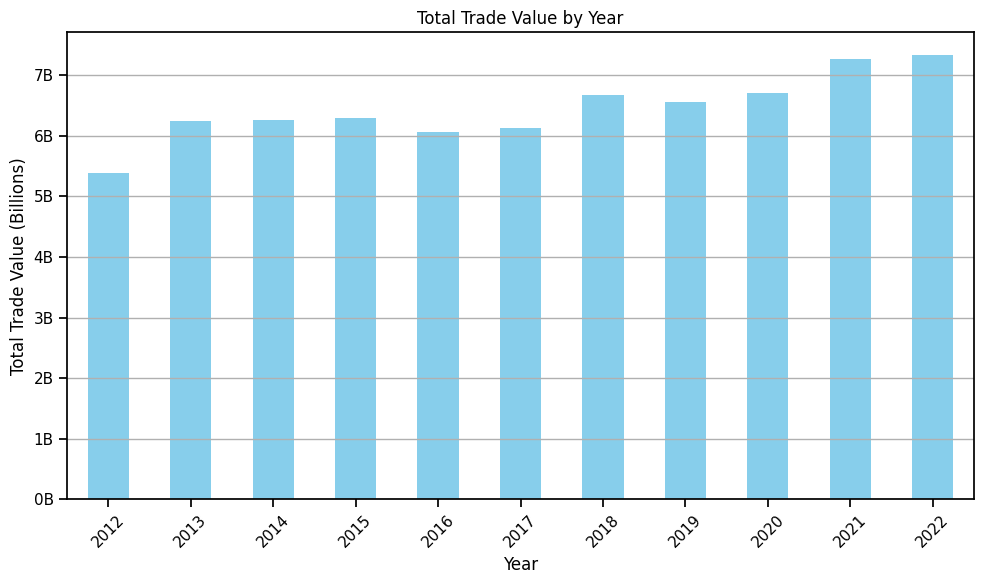

In [20]:
def billions_formatter(x, pos):
    return f'{x / 1e9:.0f}B'  # Convert value to billions and format

# Create a new formatter using the billions_formatter function
formatter = FuncFormatter(billions_formatter)

# Plotting code
plt.figure(figsize=(10, 6))
yearly_trade_sum.plot(kind='bar', color='skyblue')
plt.title('Total Trade Value by Year')
plt.xlabel('Year')
plt.ylabel('Total Trade Value (Billions)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines only on the y-axis

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

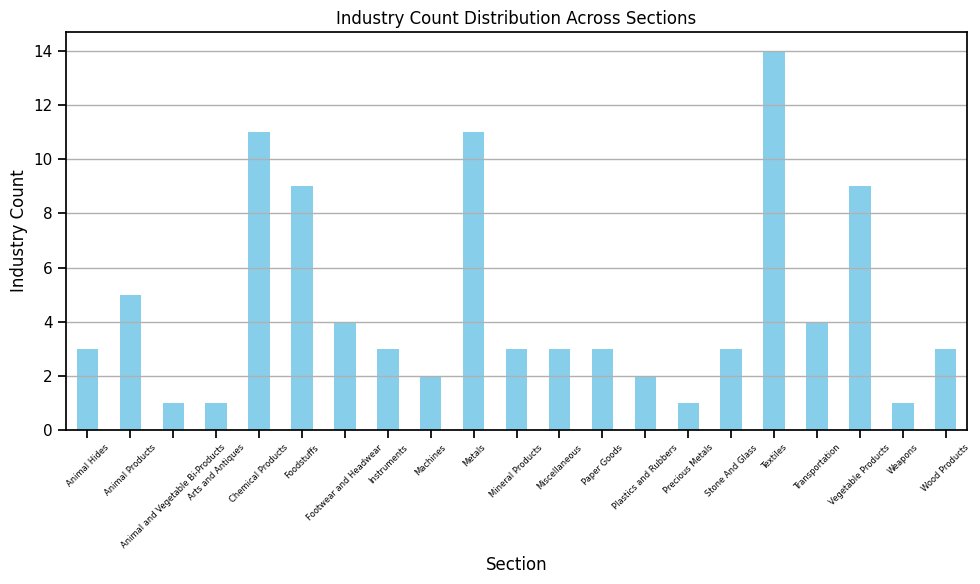

Summary Statistics for Industry Counts:
count    21.00
mean      4.57
std       3.83
min       1.00
25%       2.00
50%       3.00
75%       5.00
max      14.00
Name: HS2, dtype: float64


In [21]:
unique_products_count = df.groupby('Year')['Section'].nunique()


# Industry Count Analysis
# Calculate count of unique industries within each section
industry_counts = df.groupby('Section')['HS2'].nunique()

# Calculate summary statistics for industry counts
industry_counts_summary = industry_counts.describe()

# Visualize distribution of industry counts across sections
# Example: Bar plot for industry counts
plt.figure(figsize=(10, 6))
industry_counts.plot(kind='bar', color='skyblue')
plt.title('Industry Count Distribution Across Sections')
plt.xlabel('Section')
plt.ylabel('Industry Count')
plt.xticks(rotation=45,fontsize=6)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print summary statistics for industry counts
print("Summary Statistics for Industry Counts:")
print(industry_counts_summary)

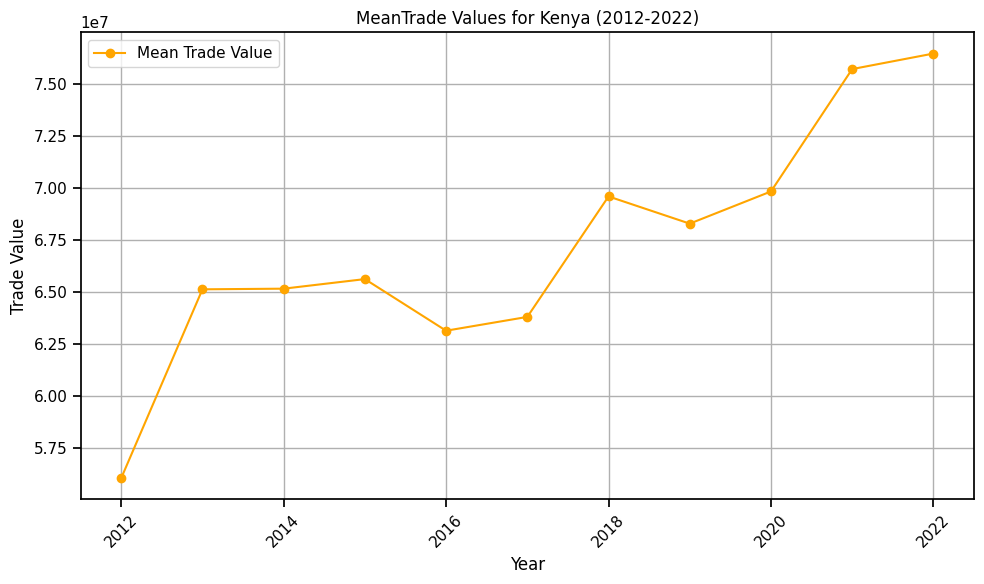

In [23]:
# Assuming you have defined the trade summary DataFrame containing yearly trade sum, mean trade value, min trade value, and max trade value
# Also assuming df contains the trade data for Kenya

# Define the trade summary DataFrame (as per your provided code)
trade_summary = pd.DataFrame({
    'Mean Trade Value': mean_trade_value_kenya,})

# Plotting separate line graphs for Mean, Min, and Max trade values
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean Trade Value
ax.plot(trade_summary.index, trade_summary['Mean Trade Value'], label='Mean Trade Value', marker='o', color='orange')


# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Trade Value')
ax.set_title('MeanTrade Values for Kenya (2012-2022)')

# Add legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

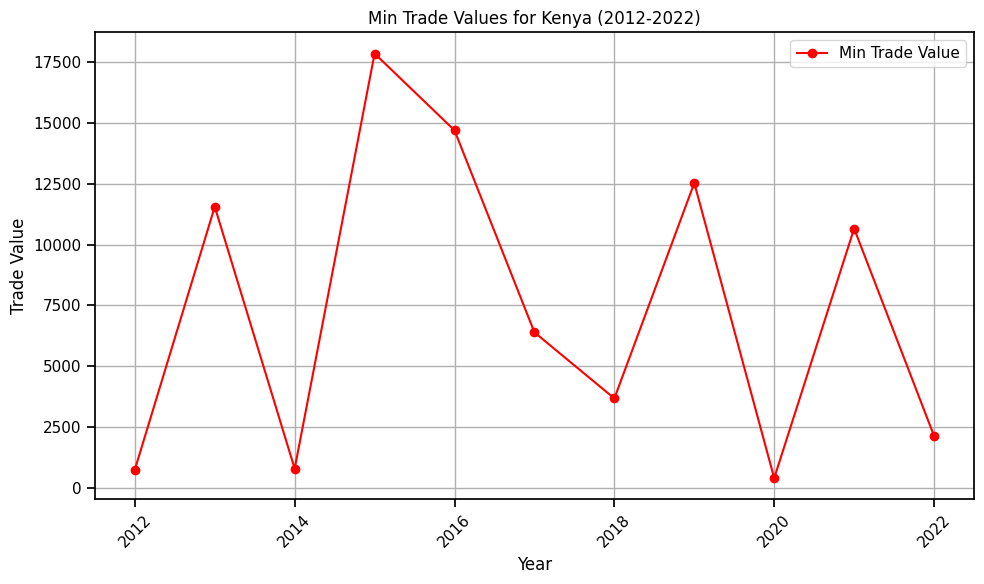

In [24]:

trade_summary = pd.DataFrame({
    'Min Trade Value': min_trade_value_kenya,})

# Plotting separate line graphs for Mean, Min, and Max trade values
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean Trade Value
ax.plot(trade_summary.index, trade_summary['Min Trade Value'], label='Min Trade Value', marker='o', color='red')


# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Trade Value')
ax.set_title('Min Trade Values for Kenya (2012-2022)')

# Add legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

Distribution of Trade by Section: Analyze the distribution of trade value across different sections to identify which sectors contribute the most to overall trade. You can calculate summary statistics (e.g., mean, median, standard deviation) of trade values for each section and visualize the distribution using histograms or box plots.

Trend Analysis: Examine the trend in trade value over time (Year) to identify any patterns or changes in trade dynamics. Plotting the trade value against time (Year) and fitting a trend line can help visualize the overall trend and identify any significant fluctuations or trends.

Comparative Analysis: Compare trade values across different HS2 categories to identify which product categories contribute the most to overall traCan calculate summary statistics for trade values within each HS2 category and compare them to assess their relative importance.

Seasonal Analysis: If the data spans multiple years, you can perform seasonal analysis to identify any seasonal patterns or fluctuations in trade values. This can help identify peak trading seasons or periods of low activity, which may influence business decisions and strategies.

Correlation Analysis: Explore the relationship between trade value and other variables such as Section ID or Industry_Count. You can calculate correlation coefficients to quantify the strength and direction of the relationship and identify any variables that may be correlated with trade value.

Outlier Detection: Identify outliers in trade values that may indicate unusual or exceptional trading activity. You can use statistical methods such as z-scores or interquartile range (IQR) to detect outliers and investigate any potential reasons for their occurrence.

Trade Dynamics by Year: Analyze how trade dynamics have evolved over the years by comparing trade values and industry counts across different years. This can help identify trends or shifts in trade patterns over time and inform future business strategies.

By performing these analyses, you can gain a deeper understanding of the trade data and extract valuable insights to inform business decisions and strategies. Feel free to choose the analyses that are most relevant to your objectives and explore additional insights based on your specific requirements.

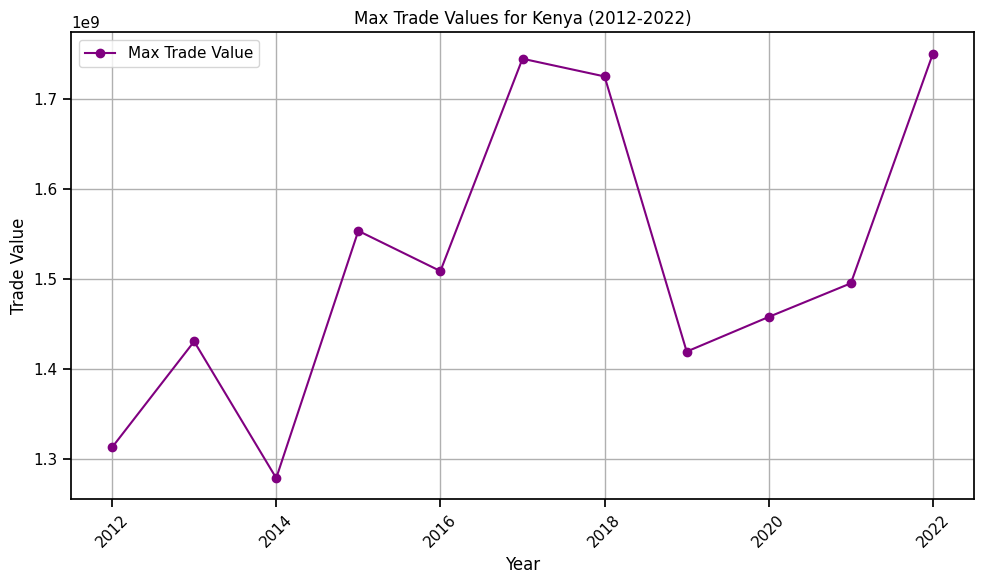

In [26]:

trade_summary = pd.DataFrame({
    'Max Trade Value': max_trade_value_kenya,})

# Plotting separate line graphs for Mean, Min, and Max trade values
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean Trade Value
ax.plot(trade_summary.index, trade_summary['Max Trade Value'], label='Max Trade Value', marker='o', color='purple')


# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Trade Value')
ax.set_title('Max Trade Values for Kenya (2012-2022)')

# Add legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
correlation_by_section_id = df.groupby('Section ID').apply(lambda x: x['Trade Value'].corr(x['Year']))




# Print the correlation coefficient for each section ID
print(correlation_by_section_id)

Section ID
1      0.07
2      0.05
3      0.88
4      0.06
5      0.07
6      0.08
7     -0.07
8     -0.27
9     -0.08
10     0.13
11     0.06
12     0.08
13     0.21
14     0.37
15     0.08
16    -0.06
17    -0.17
18     0.08
19    -0.47
20     0.26
21    -0.32
dtype: float64


C:\Users\Windows10\AppData\Local\Temp\ipykernel_33784\3012541181.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_section_id = df.groupby('Section ID').apply(lambda x: x['Trade Value'].corr(x['Year']))


# If the correlation coefficient is close to 1, it indicates a strong positive linear relationship. This means that as one variable (e.g., 'Trade Value') increases, the other variable ('Year') also tends to increase. A correlation coefficient of 1 would indicate a perfect positive correlation.

## If the correlation coefficient is close to -1, it indicates a strong negative linear relationship. This means that as one variable increases, the other variable tends to decrease. A correlation coefficient of -1 would indicate a perfect negative correlation.

## If the correlation coefficient is close to 0, it indicates little to no linear relationship between the variables. This means that changes in one variable are not associated with systematic changes in the other variable.

Interpreting the specific correlation coefficients provided:

## Values close to 0.88, 0.37, and 0.26 suggest relatively strong positive correlations. This indicates that for these 'Section IDs', there is a strong tendency for the 'Trade Value' to increase as the 'Year' increases.

## Values close to -0.47, -0.32, and -0.27 suggest relatively strong negative correlations. This indicates that for these 'Section IDs', there is a strong tendency for the 'Trade Value' to decrease as the 'Year' increases.

## Values close to 0 or around 0.05, 0.06, etc., suggest weak correlations. This means that there is little to no linear relationship between the 'Trade Value' and 'Year' for these 'Section IDs'.